# Movie recommender

## Libraries

In [1]:
import pandas as pd
from pathlib import Path
from typing import List, Dict
from tqdm import tqdm
import seaborn as sns
import numpy as np

## Data

The data is an excerpt from the Movielens dataset. 

In [2]:
myurl = "https://liangfgithub.github.io/MovieData/"

In [3]:
!cat ../data/README

SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a facult

In [3]:
# dict with age groups:
age_dict = {
    1:  "Under 18",
    18:  "18-24",
    25:  "25-34",
    35:  "35-44",
    45:  "45-49",
    50:  "50-55",
    56:  "56+"
}

# dict with occupations:
occupations_dict = {
    0:  "other",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}

In [4]:
datapath = Path("../data/")

In [5]:
def load_data(path: Path, header: List[str], ignore_index=True) -> pd.DataFrame:
    with open(path, mode='r', encoding='iso8859-1') as f:
        lines = f.readlines()
    df = pd.DataFrame(map(parse_line, lines), columns=header)
    return df

def parse_line(line: str, sep="::", ignore_index=True) -> List[str]:
    row = line.split(sep=sep)
    row = [s.strip() for s in row]
    #row = dict(zip(header, row))
    if ignore_index: pass
        #row = row[1:]
    return row

In [6]:
users = load_data(datapath/"users.dat", header=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [7]:
ratings = load_data(datapath/"ratings.dat", header=['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [8]:
movies = load_data(datapath/"movies.dat", header=['MovieID', 'Title', 'Genres', ])
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


### Preprocessing

Convert numbers to integers:

In [9]:
users['UserID'] = users['UserID'].astype(int)
users['Age'] = users['Age'].astype(int)
users['Occupation'] = users['Occupation'].astype(int)

In [10]:
movies['MovieID'] = movies['MovieID'].astype(int)

In [11]:
ratings['UserID'] = ratings['UserID'].astype(int)
ratings['MovieID'] = ratings['MovieID'].astype(int)
ratings['Rating'] = ratings['Rating'].astype(int)

Convert timestamp to datetime:

In [12]:
ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')

/tmp/ipykernel_41424/2279367575.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')


Extract movie names for R matrix

In [13]:
# Create dict of movie names and movie ids
movie_dict = dict(zip(movies['MovieID'], movies['Title']))
movie_dict_inv = dict(zip(movies['Title'], movies['MovieID']))

In [14]:
len(movie_dict)

3883

Split genres into array

In [15]:
# Split genres into np.array
movies['Genres'] = movies['Genres'].apply(lambda x: np.array(x.split('|')))

In [16]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy]
3879,3949,Requiem for a Dream (2000),[Drama]
3880,3950,Tigerland (2000),[Drama]
3881,3951,Two Family House (2000),[Drama]


In [17]:
print(movies.iloc[0]['Genres'])
print("Comedy" in movies.iloc[0]['Genres'])
print("Thriller" in movies.iloc[0]['Genres'])

['Animation' "Children's" 'Comedy']
True
False


These are the movie genres:

In [18]:
all_genres = movies['Genres'].explode().unique()
all_genres

array(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir',
       'Western'], dtype=object)

In [25]:
def id2title(movie_id: int, movie_dict: dict) -> str:
    """Get movie title from movie id

    Args:
        movie_id (int): Movie id
        movie_dict (dict): Dictionary with movie ids as keys and movie titles as values

    Returns:
        str: Movie title
    """
    assert type(movie_id) == int, "Movie id must be integer"
    if movie_id in movie_dict.keys():
        title = movie_dict[movie_id]
    else:
        title = f"MovieID_{movie_id}"
    return title

In [27]:
# id2title for Rmat using different indeces
def strid2title(movie_id: str, movie_dict: dict) -> str:
    """Get movie title from movie id

    Args:
        movie_id (str): Movie id
        movie_dict (dict): Dictionary with movie ids as keys and movie titles as values

    Returns:
        str: Movie title
    """
    assert type(movie_id)==str, "movie_id must be of type str"
    movie_id = int(movie_id.split("m")[1]) # remove "m" from string and convert to int
    if movie_id in movie_dict.keys():
        title = movie_dict[int(movie_id)]
    else:
        title = f"MovieID_{movie_id}"
    return title

## Explore data

These are the genders:

In [13]:
users['Gender'].value_counts()

Gender
M    4331
F    1709
Name: count, dtype: int64

In [14]:
users['Age'].value_counts()

Age
25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: count, dtype: int64

In [15]:
users['Age'].unique()

array([ 1, 56, 25, 45, 50, 35, 18])

In [16]:
users['Occupation'].value_counts()

Occupation
4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: count, dtype: int64

In [17]:
users['Occupation'].apply(lambda x: occupations_dict[x])

0               K-12 student
1              self-employed
2                  scientist
3       executive/managerial
4                     writer
                ...         
6035               scientist
6036       academic/educator
6037       academic/educator
6038                   other
6039      doctor/health care
Name: Occupation, Length: 6040, dtype: object

How many unique movies are there?

In [18]:
movies['MovieID'].nunique()

3883

In [19]:
ratings['MovieID'].nunique()

3706

Not all movies are rated by all users.

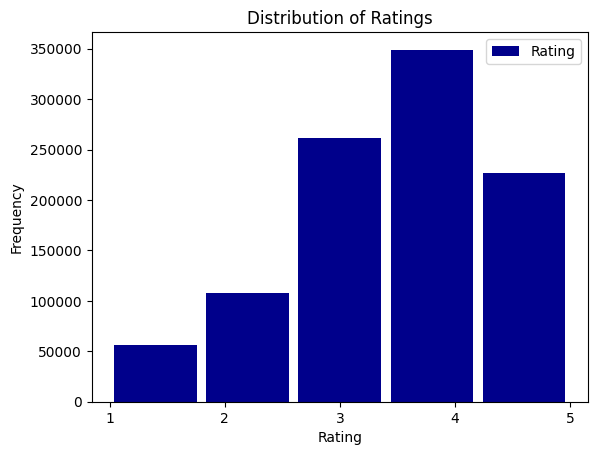

In [20]:
# Distribution of ratings

import matplotlib.pyplot as plt

ratings['Rating'].hist(bins=5, grid=False, align='mid', rwidth=0.9, color='darkblue', label='Rating')
plt.xticks(range(1, 6))  # Set the x-axis ticks to range from 1 to 5
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.legend()
plt.show()


## Build recommender System I

Recommendation based on genres:

Imagine you know the user’s favorite movie genre. How would you recommend movies to them?

Propose a recommendation scheme along with all the technical details necessary to implement it. For example, you can recommend the top five most popular movies in that genre, but you need to define what you mean by “most popular.” Similarly, you can recommend the top five highly-rated movies in that genre, but you must specify how you define “highly-rated.” (Will the movie that receives only one 5-point review be considered highly rated?)

- The proposal for "most popular" is to recommend the movies with the highest number of ratings. 
- The proposal for "highly-rated" is to recommend the movies with the highest rating.

<Axes: >

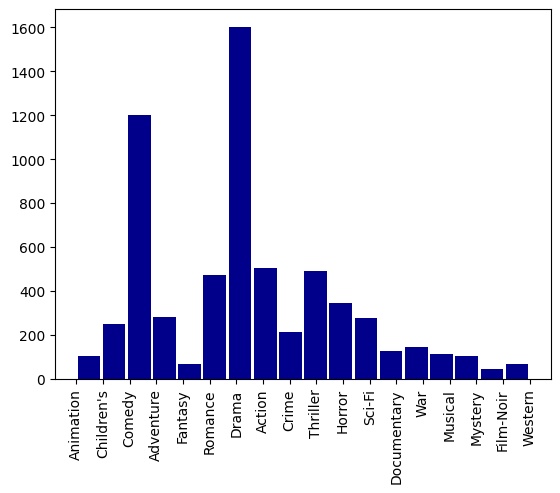

In [18]:
# Distribution of ratings per genre

movies.Genres.explode().hist(xrot=90, bins=len(all_genres), grid=False, align='mid', rwidth=0.9, color='darkblue', label='Rating')

In [19]:
# get MovieIDs of movies with genre
genre = "Animation"
movie_ids = movies[movies['Genres'].apply(lambda x: genre in x)]['MovieID'].unique()

In [20]:
movie_ids

array([   1,   13,   48,  239,  244,  313,  364,  558,  588,  594,  595,
        596,  610,  616,  631,  661,  673,  709,  720,  741,  745,  783,
        888, 1022, 1023, 1024, 1025, 1029, 1030, 1032, 1033, 1064, 1148,
       1151, 1205, 1223, 1274, 1282, 1405, 1489, 1566, 1688, 1881, 1907,
       1920, 2018, 2033, 2048, 2078, 2080, 2081, 2085, 2087, 2089, 2090,
       2092, 2096, 2099, 2102, 2116, 2123, 2137, 2138, 2139, 2141, 2142,
       2189, 2294, 2354, 2355, 2394, 2495, 2559, 2566, 2687, 2700, 2761,
       2800, 2810, 2857, 2876, 2899, 2987, 3000, 3034, 3054, 3114, 3159,
       3213, 3287, 3400, 3429, 3483, 3592, 3611, 3615, 3725, 3745, 3751,
       3754, 3759, 3775, 3776, 3799, 3945])

In [21]:
movies.loc[movies['MovieID'].isin(movie_ids), 'Title'].unique()

array(['Toy Story (1995)', 'Balto (1995)', 'Pocahontas (1995)',
       'Goofy Movie, A (1995)', 'Gumby: The Movie (1995)',
       'Swan Princess, The (1994)', 'Lion King, The (1994)',
       'Pagemaster, The (1994)', 'Aladdin (1992)',
       'Snow White and the Seven Dwarfs (1937)',
       'Beauty and the Beast (1991)', 'Pinocchio (1940)',
       'Heavy Metal (1981)', 'Aristocats, The (1970)',
       'All Dogs Go to Heaven 2 (1996)',
       'James and the Giant Peach (1996)', 'Space Jam (1996)',
       'Oliver & Company (1988)',
       'Wallace & Gromit: The Best of Aardman Animation (1996)',
       'Ghost in the Shell (Kokaku kidotai) (1995)',
       'Close Shave, A (1995)', 'Hunchback of Notre Dame, The (1996)',
       'Land Before Time III: The Time of the Great Giving (1995)',
       'Cinderella (1950)', 'Winnie the Pooh and the Blustery Day (1968)',
       'Three Caballeros, The (1945)', 'Sword in the Stone, The (1963)',
       'Dumbo (1941)', "Pete's Dragon (1977)",
       'Alice

<Axes: >

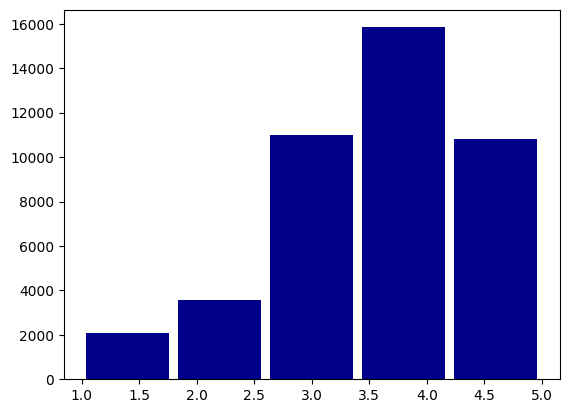

In [22]:
# Get ratings of movies with genre
ratings[ratings['MovieID'].isin(movie_ids)]['Rating'].hist(bins=5, grid=False, align='mid', rwidth=0.9, color='darkblue', label='Rating')

- The proposal for "most popular" is to recommend the movies with the highest number of ratings. 
- The proposal for "highly-rated" is to recommend the movies with the highest rating.

In [84]:
def get_top_n_most_popular_movies_by_genre(movies: pd.DataFrame, 
                                           ratings: pd.DataFrame, 
                                           genre: str, 
                                           n: int, 
                                           top: bool = True) -> List[str]:
""Get top n most popular movies by genre (movies with highest or lowest number of ratings)

    Args:
        movies (pd.DataFrame): Movies dataframe
        ratings (pd.DataFrame): Ratings dataframe
        genre (str): Genre to filter movies by
        n (int): Number of movies to return
        top (bool, optional): Whether to return top or bottom n movies. Defaults to True.

    Returns:
        List[str]: List of movie names
""
    all_genres = movies['Genres'].explode().unique()
    assert genre in all_genres, f"Genre {genre} not found in list of genres"
    movie_ids = movies[movies['Genres'].apply(lambda x: genre in x)]['MovieID'].unique()
    if top:
        idx = ratings[ratings['MovieID'].isin(movie_ids)].value_counts().head(n).index.get_level_values(1).values
    else:
        idx = ratings[ratings['MovieID'].isin(movie_ids)].value_counts().tail(n).index.get_level_values(1).values
    return list(movies.loc[movies['MovieID'].isin(idx), 'Title'].unique())

In [85]:
get_top_n_most_popular_movies_by_genre(movies, ratings, "Animation", 5, top=True)

['Toy Story (1995)',
 'Sword in the Stone, The (1963)',
 'Dumbo (1941)',
 "Pete's Dragon (1977)",
 'Jungle Book, The (1967)']

In [86]:
get_top_n_most_popular_movies_by_genre(movies, ratings, "Action", 5, top=True)

['Star Wars: Episode IV - A New Hope (1977)',
 'Lethal Weapon (1987)',
 'Lethal Weapon 2 (1989)',
 'Lethal Weapon 3 (1992)',
 'Wild Wild West (1999)']

In [87]:
get_top_n_most_popular_movies_by_genre(movies, ratings, "Action", 5, top=False)

['Mad Max (1979)',
 'Mad Max 2 (a.k.a. The Road Warrior) (1981)',
 'Mad Max Beyond Thunderdome (1985)',
 'Action Jackson (1988)']

In [19]:
def get_top_n_highly_rated_movies_by_genre(movies: pd.DataFrame, 
                                           ratings: pd.DataFrame, 
                                           genre: str, 
                                           n: int, 
                                           top: bool = True) -> List[str]:
    """Get top n most highly rated movies by genre (movies with highest or lowest average rating)

    Args:
        movies (pd.DataFrame): Movies dataframe
        ratings (pd.DataFrame): Ratings dataframe
        genre (str): Genre to filter movies by
        n (int): Number of movies to return
        top (bool, optional): Whether to return top or bottom n movies. Defaults to True.

    Returns:
        List[str]: List of movie names
    """
    all_genres = movies['Genres'].explode().unique()
    assert genre in all_genres, f"Genre {genre} not found in list of genres"
    movie_ids = movies[movies['Genres'].apply(lambda x: genre in x)]['MovieID'].unique()
    if top:
        idx = ratings[ratings['MovieID'].isin(movie_ids)].groupby(by='MovieID').mean().sort_values(by='Rating', ascending=False).head(n).index.values
    else:
        idx = ratings[ratings['MovieID'].isin(movie_ids)].groupby(by='MovieID').mean().sort_values(by='Rating', ascending=True).head(n).index.values
    #print(movies.loc[movies['MovieID'].isin(idx)])
    return list(movies.loc[movies['MovieID'].isin(idx), 'Title'].unique())

Get top 100 movies

In [21]:
def get_top_100_highly_rated_movies_all_genres():
    """Get top 100 most highly rated movies for all genres

    Returns:
        List[str]: List of movie names
    """
    return list(ratings.groupby(by='MovieID').mean().sort_values(by='Rating', ascending=False).head(100).index.values)

In [30]:
top_100 = get_top_100_highly_rated_movies_all_genres()


In [34]:
{int(t):id2title(int(t), movie_dict) for t in top_100}

{989: 'Schlafes Bruder (Brother of Sleep) (1995)',
 3881: 'Bittersweet Motel (2000)',
 1830: 'Follow the Bitch (1998)',
 3382: 'Song of Freedom (1936)',
 787: 'Gate of Heavenly Peace, The (1995)',
 3280: 'Baby, The (1973)',
 3607: 'One Little Indian (1973)',
 3233: 'Smashing Time (1967)',
 3172: 'Ulysses (Ulisse) (1954)',
 3656: 'Lured (1947)',
 3245: 'I Am Cuba (Soy Cuba/Ya Kuba) (1964)',
 53: 'Lamerica (1994)',
 2503: 'Apple, The (Sib) (1998)',
 2905: 'Sanjuro (1962)',
 2019: 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)',
 318: 'Shawshank Redemption, The (1994)',
 858: 'Godfather, The (1972)',
 745: 'Close Shave, A (1995)',
 50: 'Usual Suspects, The (1995)',
 527: "Schindler's List (1993)",
 1148: 'Wrong Trousers, The (1993)',
 2309: 'Inheritors, The (Die Siebtelbauern) (1998)',
 1795: 'Callejón de los milagros, El (1995)',
 2480: 'Dry Cleaning (Nettoyage à sec) (1997)',
 439: 'Dangerous Game (1993)',
 557: 'Mamma Roma (1962)',
 3517: 'Bells, The (1926)',
 388

In [20]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Animation", 5, top=True)

['Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Close Shave, A (1995)',
 'Wrong Trousers, The (1993)',
 'Grand Day Out, A (1992)',
 'Creature Comforts (1990)']

In [154]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Animation", 5, top=False)

['Gumby: The Movie (1995)',
 'All Dogs Go to Heaven 2 (1996)',
 'Pokémon: The First Movie (1998)',
 'Pokémon the Movie 2000 (2000)',
 'Digimon: The Movie (2000)']

In [159]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Sci-Fi", 10, top=True)

['Star Wars: Episode IV - A New Hope (1977)',
 'Blade Runner (1982)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Brazil (1985)',
 'Aliens (1986)',
 'Alien (1979)',
 'Terminator, The (1984)',
 'Day the Earth Stood Still, The (1951)',
 'Matrix, The (1999)']

In [160]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Sci-Fi", 5, top=False)

['Adrenalin: Fear the Rush (1996)',
 'Time Tracers (1995)',
 'Carnosaur 2 (1995)',
 'Carnosaur 3: Primal Species (1996)',
 'Battlefield Earth (2000)']

In [161]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Thriller", 5, top=False)

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Bloody Child, The (1996)',
 'Underworld (1997)',
 'Puppet Master 5: The Final Chapter (1994)',
 'Retro Puppetmaster (1999)']

In [162]:
get_top_n_highly_rated_movies_by_genre(movies, ratings, "Thriller", 5, top=True)

['Usual Suspects, The (1995)',
 'Close Shave, A (1995)',
 'Rear Window (1954)',
 'Third Man, The (1949)',
 'Sixth Sense, The (1999)']

## Build recommender System II

### Recommendation based on item-based collaborative filtering

#### Normalize ratings

In [20]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:16
1,1,661,3,2000-12-31 22:34:40
2,1,914,3,2000-12-31 22:32:32
3,1,3408,4,2000-12-31 22:04:48
4,1,2355,5,2001-01-06 23:38:40
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:44
1000205,6040,1094,5,2000-04-25 23:21:36
1000206,6040,562,5,2000-04-25 23:19:28
1000207,6040,1096,4,2000-04-26 02:20:48


In [21]:
# Create rating matrix users x movies
# NaN values are not rated movies
# rows: users
# columns: movies
# values: ratings
R = ratings.pivot(index='UserID', columns='MovieID', values='Rating')

In [22]:
# The Rmat rating matrix from coursera
Rmat = pd.read_csv(datapath/"Rmat.csv", index_col=0)

In [23]:
Rmat

,m1,m10,m100,m1000,m1002,m1003,m1004,m1005,m1006,m1007,...,m99,m990,m991,m992,m993,m994,m996,m997,m998,m999
u1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u10,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1000,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1001,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u996,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
u997,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
R.shape==Rmat.shape

True

In [25]:
R

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
ratings.pivot(index='UserID', columns='MovieID', values='Rating')

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
Rmat

,m1,m10,m100,m1000,m1002,m1003,m1004,m1005,m1006,m1007,...,m99,m990,m991,m992,m993,m994,m996,m997,m998,m999
u1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u10,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1000,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1001,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u996,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
u997,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
movie_names = R.columns.map(lambda x: id2title(x, movie_dict))
movie_names

Index(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)',
       'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)',
       'Sudden Death (1995)', 'GoldenEye (1995)',
       ...
       'Bamboozled (2000)', 'Bootmen (2000)', 'Digimon: The Movie (2000)',
       'Get Carter (2000)', 'Get Carter (1971)', 'Meet the Parents (2000)',
       'Requiem for a Dream (2000)', 'Tigerland (2000)',
       'Two Family House (2000)', 'Contender, The (2000)'],
      dtype='object', name='MovieID', length=3706)

In [31]:
R.columns = movie_names
R

MovieID,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Bamboozled (2000),Bootmen (2000),Digimon: The Movie (2000),Get Carter (2000),Get Carter (1971),Meet the Parents (2000),Requiem for a Dream (2000),Tigerland (2000),Two Family House (2000),"Contender, The (2000)"
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# We don't swap column names for Rmat because we want to keep the original column names
#movie_names = Rmat.columns.map(lambda x: strid2title(x, movie_dict))
#Rmat.columns = movie_names
Rmat

,m1,m10,m100,m1000,m1002,m1003,m1004,m1005,m1006,m1007,...,m99,m990,m991,m992,m993,m994,m996,m997,m998,m999
u1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u10,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1000,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1001,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u996,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
u997,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
R.sum(axis=0).sort_values(ascending=False).index[:10]

Index([2858, 260, 1196, 1210, 2028, 1198, 593, 2571, 2762, 589], dtype='int64', name='MovieID')

In [68]:
Rmat.sum(axis=0).sort_values(ascending=False).index[:10]

Index(['m2858', 'm260', 'm1196', 'm1210', 'm2028', 'm1198', 'm593', 'm2571',
       'm2762', 'm589'],
      dtype='object')

In [69]:
idx_top_10_popular = R.sum(axis=0).sort_values(ascending=False).index[:10]
print(idx_top_10_popular)
list(map(lambda x: movie_dict_inv[x], idx_top_10_popular))

Index(['American Beauty (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Saving Private Ryan (1998)', 'Raiders of the Lost Ark (1981)',
       'Silence of the Lambs, The (1991)', 'Matrix, The (1999)',
       'Sixth Sense, The (1999)', 'Terminator 2: Judgment Day (1991)'],
      dtype='object', name='MovieID')


[2858, 260, 1196, 1210, 2028, 1198, 593, 2571, 2762, 589]

In [70]:
tops = R.sum(axis=0)
# extract numerical index from index
tops


MovieID
Toy Story (1995)                      8613.0
Jumanji (1995)                        2244.0
Grumpier Old Men (1995)               1442.0
Waiting to Exhale (1995)               464.0
Father of the Bride Part II (1995)     890.0
                                       ...  
Meet the Parents (2000)               3134.0
Requiem for a Dream (2000)            1251.0
Tigerland (2000)                       198.0
Two Family House (2000)                156.0
Contender, The (2000)                 1467.0
Length: 3706, dtype: float64

In [71]:
movie_names

Index(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)',
       'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)',
       'Sudden Death (1995)', 'GoldenEye (1995)',
       ...
       'Bamboozled (2000)', 'Bootmen (2000)', 'Digimon: The Movie (2000)',
       'Get Carter (2000)', 'Get Carter (1971)', 'Meet the Parents (2000)',
       'Requiem for a Dream (2000)', 'Tigerland (2000)',
       'Two Family House (2000)', 'Contender, The (2000)'],
      dtype='object', name='MovieID', length=3706)

In [72]:
R.index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
      dtype='int64', name='UserID', length=6040)

In [73]:
# Normalize rating matrix R by centering each row around its mean (ignore NaN values)
R_norm = R.sub(R.mean(axis=1, skipna=True), axis=0)

In [75]:
# Normalize rating matrix Rmat (from Coursera) by centering each row around its mean (ignore NaN values)
Rmat_norm = Rmat.sub(Rmat.mean(axis=1, skipna=True), axis=0)

In [76]:
R_norm

MovieID,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Bamboozled (2000),Bootmen (2000),Digimon: The Movie (2000),Get Carter (2000),Get Carter (1971),Meet the Parents (2000),Requiem for a Dream (2000),Tigerland (2000),Two Family House (2000),"Contender, The (2000)"
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.811321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.146465,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,-1.302928,NaN,-0.302928,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
Rmat_norm

,m1,m10,m100,m1000,m1002,m1003,m1004,m1005,m1006,m1007,...,m99,m990,m991,m992,m993,m994,m996,m997,m998,m999
u1,0.811321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u10,0.885287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1000,0.869048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1001,0.347480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u996,0.064189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.935811
u997,0.066667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate the cosine similarity between each pair of users


$$S_{ij} = \frac{1}{2} + \frac{1}{2}\frac{\sum_{l \in \mathcal{I_{ij}}}{R_{li}R_{lj}}}{\sqrt{\sum_{l \in \mathcal{I_{ij}}}{R_{li}^2}}\sqrt{\sum_{l \in \mathcal{I_{ij}}}{R_{lj}^2}}}$$

$\mathcal{I_{ij}}$ is the movie which users i and j have both rated.

In [78]:
R_np = np.array(R_norm)

In [79]:
Rmat_np = np.array(Rmat_norm)

In [80]:
R_np.shape

(6040, 3706)

In [81]:
R_np

array([[ 0.81132075,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.57771261,         nan,         nan, ...,         nan,
                nan,         nan]])

In [82]:
Rmat_np

array([[0.81132075,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.88528678,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.06666667,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [83]:
n_movies = R_np.shape[1]

In [84]:
R_zeros = R_np.copy()
R_zeros[np.isnan(R_np)] = 0

In [85]:
Rmat_zeros = Rmat_np.copy()
Rmat_zeros[np.isnan(Rmat_zeros)] = 0

In [86]:
R_zeros

array([[ 0.81132075,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57771261,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [87]:
Rmat_zeros

array([[0.81132075, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.88528678, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

For each row, sort the non-NA similarity measures and keep the top 30, setting the rest to NA. This new similarity matrix, still denoted as S, is no longer symmetric.

#### cosine similarity with top 30 movies

The following has different versions of computing cosine similarity

This version has a nested for loop and uses np.argpartition to find the top 30 movies. It also implements the boundary conditions fomulated in the instructions. It sets the NaN values to 0.

$$S_{ij} = \frac{1}{2} + \frac{1}{2}\frac{\sum_{l \in \mathcal{I_{ij}}}{R_{li}R_{lj}}}{\sqrt{\sum_{l \in \mathcal{I_{ij}}}{R_{li}^2}}\sqrt{\sum_{l \in \mathcal{I_{ij}}}{R_{lj}^2}}}$$

$\mathcal{I_{ij}}$ is the movie which users i and j have both rated.

In [88]:
R_zeros[0, :] != 0

array([ True, False, False, ..., False, False, False])

In [89]:
R_zeros[0,:]

array([0.81132075, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [90]:
def compute_top_k_cosine_similarity_skipping_zeros(R: np.array, k: int=30 )-> np.ndarray:
    n_movies = R.shape[1]
    S = np.zeros((n_movies, n_movies))
    eps = 1e-10

    for i in tqdm(range(n_movies)):
        # Use broadcasting to find set of non-zero users for both columns i and j
        valid_indices = R[:, i] != 0

        for j in range(i + 1, n_movies):
            # Find common valid indices for both columns i and j (i.e. a binary mask of valid indices for both columns)
            l = valid_indices & (R[:, j] != 0) # logical and to check the movies was rated by the same user

            if np.sum(l) >= 3:
                dot_prod = np.sum(R[l, i] * R[l, j])
                norm_i = np.linalg.norm(R[l, i])
                norm_j = np.linalg.norm(R[l, j])

                S[i, j] = 0.5 + 0.5 * (dot_prod / (norm_i * norm_j + eps))

        # Keep only top k
        top_k_indices = np.argpartition(S[i, :], -k)[-k:] # get top k indices
        # Set all indices not in top k to 0
        S[i, :][~np.isin(np.arange(n_movies), top_k_indices)] = 0 #S[i, ~top_k_indices] = 0
    return S


In [44]:
S_k = compute_top_k_cosine_similarity_skipping_zeros(R_zeros, k=30)

  1%|          | 24/3706 [00:07<20:07,  3.05it/s]


KeyboardInterrupt: 

In [91]:
Smat_k = compute_top_k_cosine_similarity_skipping_zeros(Rmat_zeros, k=30)

100%|██████████| 3706/3706 [08:35<00:00,  7.19it/s] 


In [104]:
pd.DataFrame(S_k)

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.491852,0.425333,0.307334,0.506547
3702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.594070,0.656516,0.566232
3703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.662502,0.573728
3704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.690165


In [105]:
pd.DataFrame(Smat_k)

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.215561,0.449014,0.307824,0.398517
3702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.077113,0.556378,0.622558
3703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.642635,0.460646
3704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.642727


Computing cosine similarity

Check if any NaN values were produced (e.g. divide by zero)

In [85]:
sum(np.isnan(S_k))

array([0, 0, 0, ..., 0, 0, 0])

In [95]:
sum(np.isnan(Smat_k))

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
np.isnan(S_k).sum(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [87]:
# Save similarity matrix
np.save(datapath/"similarity_matrix_top_k.npy", S_k)

In [101]:
# Save similarity matrix
np.save(datapath/"similarity_matrix_top_k_from_Rmat.npy", Smat_k)

In [102]:
S_k = np.load(datapath/"similarity_matrix_top_k.npy")

In [103]:
Smat_k = np.load(datapath/"similarity_matrix_top_k_from_Rmat.npy")

#### Exploration of the similarity matrix

In [49]:
from matplotlib import pyplot as plt

Computed by nested loop version

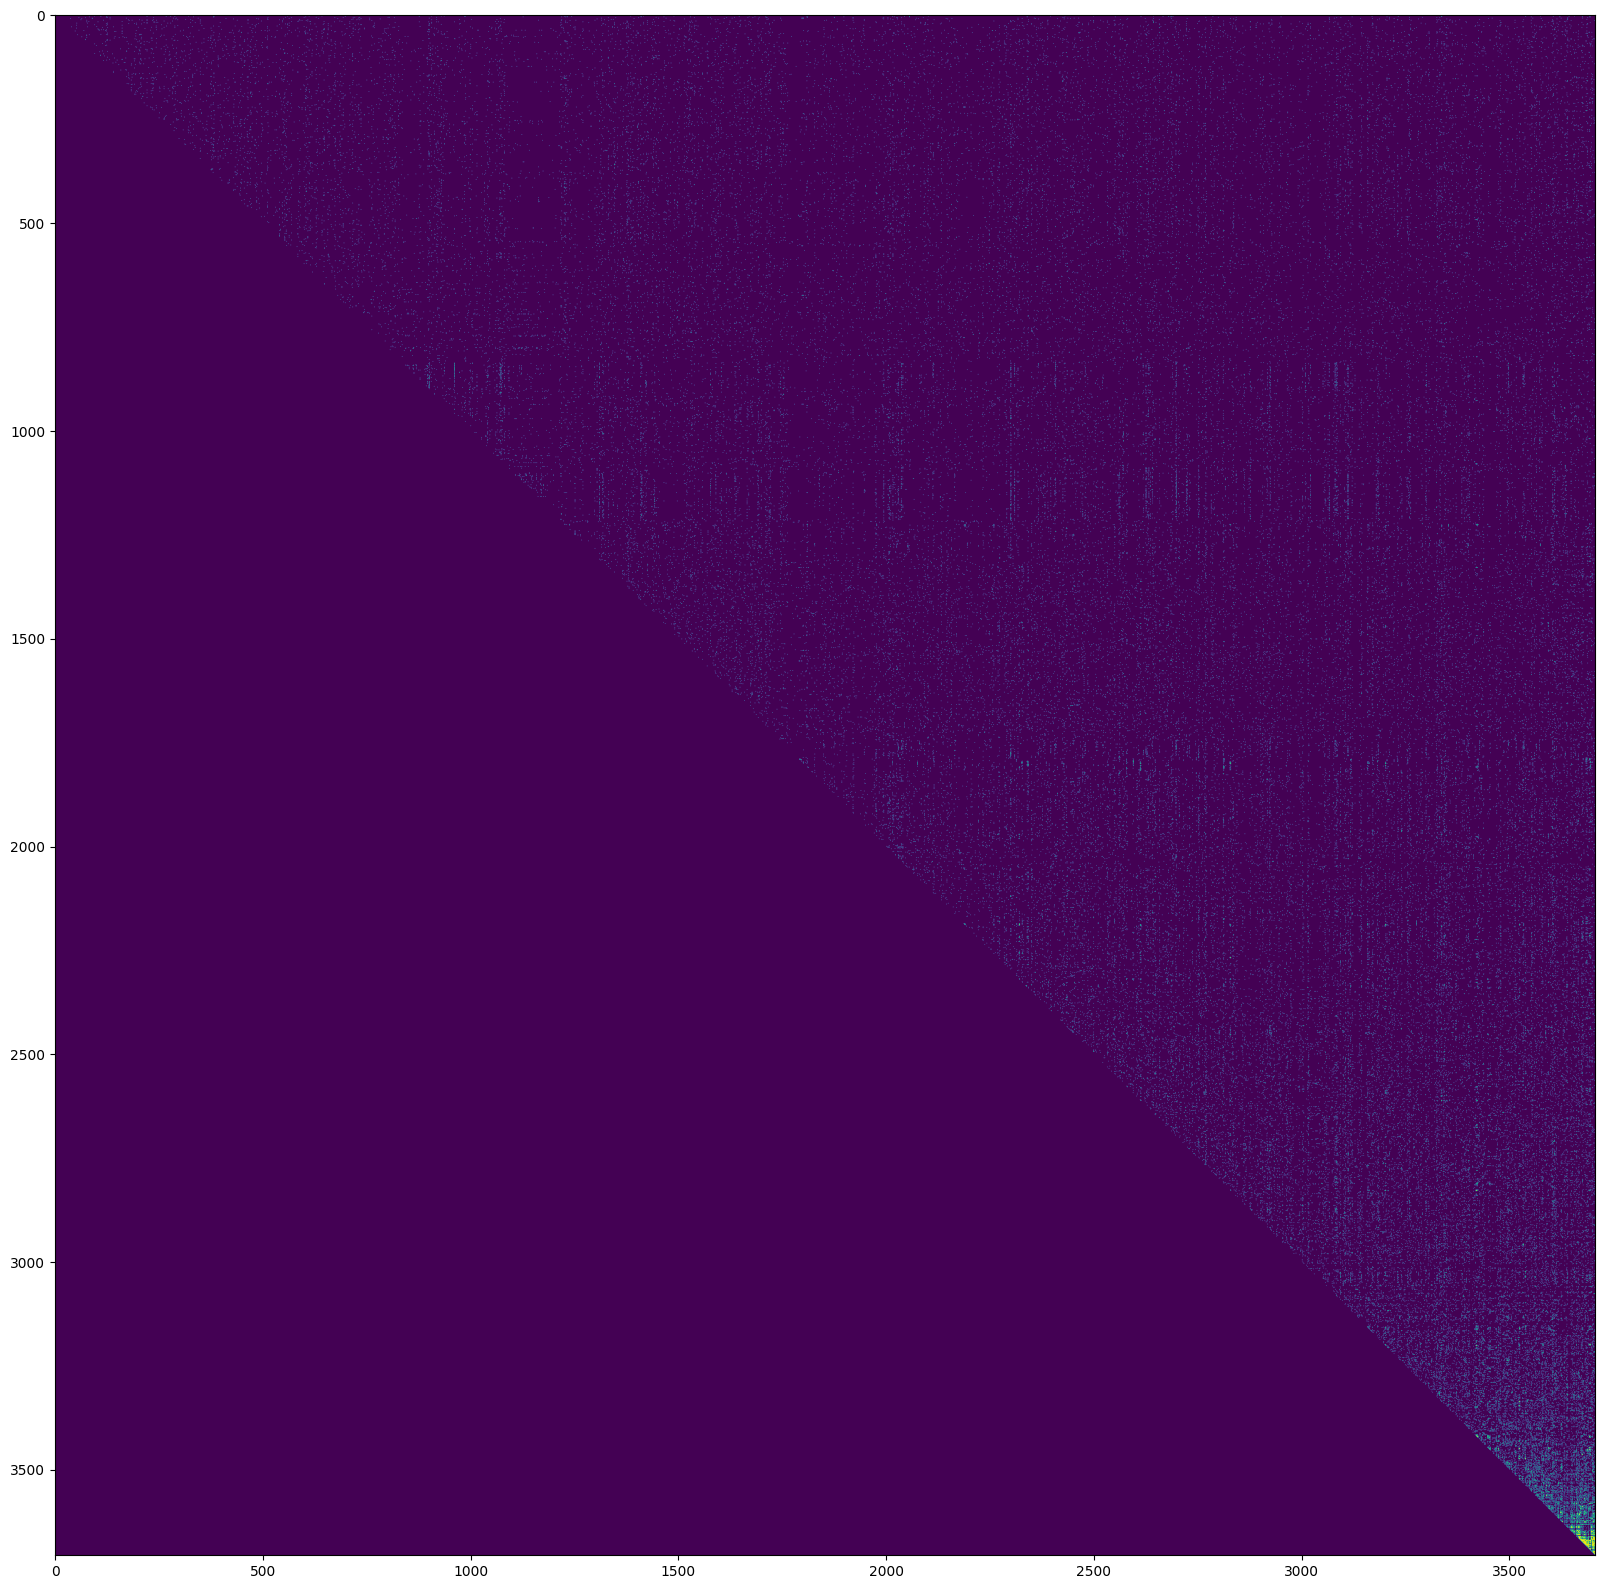

In [44]:
eps = 1e-10
plt.figure(figsize=(20, 20))
#plt.imshow(np.log(S_k[::-1,::-1].T+eps))
plt.imshow(np.log(S_k+eps))

Computed by "vectorized" single loop version

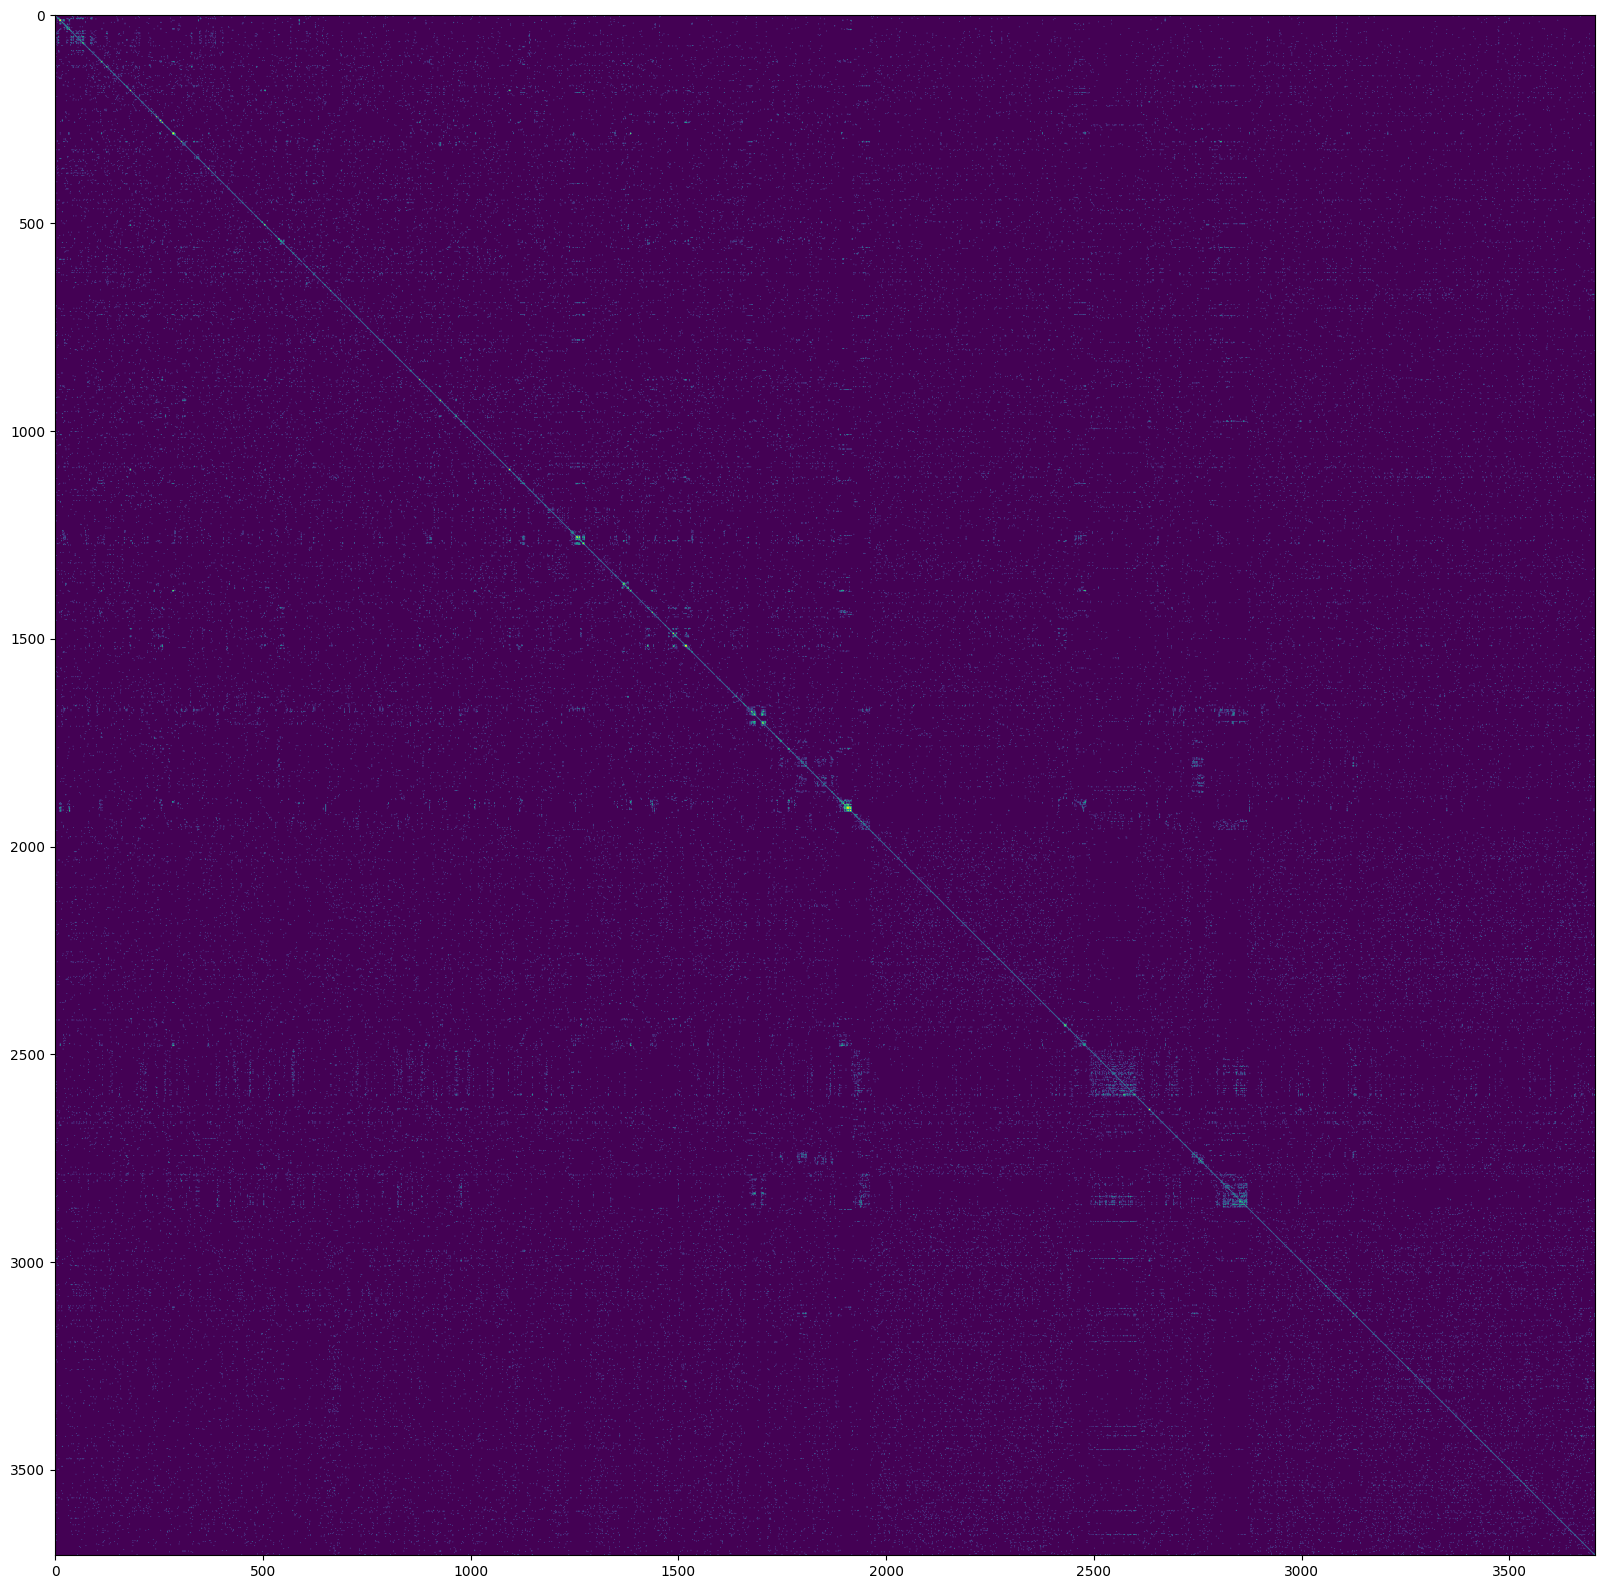

In [74]:
S = np.load(datapath/"similarity_matrix_top_k_old.npy")
eps = 1e-10
plt.figure(figsize=(20, 20))
plt.imshow(np.log(S[::-1,::-1].T+eps))

Output the movies “m1”, “m10”, “m100”, “m1510”, “m260”, “m3212”. Index minus one to go from R to Python indexing.

In [50]:
indeces = np.array([0, 9, 99, 1509, 259, 3211])
for i, j in enumerate(indeces[:-1]):
    print(np.round(S_k[j,indeces[i+1]],7))

0.0
0.0
0.0
0.0
0.8857272


In [106]:
indeces = np.array([0, 9, 99, 1509, 259, 3211])
for i, j in enumerate(indeces[:-1]):
    print(np.round(Smat_k[j,indeces[i+1]],7))

0.0
0.0
0.0
0.0
0.0


In [51]:
pd.DataFrame(S_k).iloc[indeces, indeces]    

,0,9,99,1509,259,3211
0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.0,0.0,0.0,0.0,0.0,0.848407
99,0.0,0.0,0.0,0.0,0.0,0.000000
1509,0.0,0.0,0.0,0.0,0.0,0.000000
259,0.0,0.0,0.0,0.0,0.0,0.885727
3211,0.0,0.0,0.0,0.0,0.0,0.000000


In [107]:
pd.DataFrame(Smat_k).iloc[indeces, indeces]    

,0,9,99,1509,259,3211
0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0
1509,0.0,0.0,0.0,0.0,0.0,0.0
259,0.0,0.0,0.0,0.0,0.0,0.0
3211,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
R.columns[indeces]

Index(['Toy Story (1995)', 'GoldenEye (1995)', 'Mr. Wrong (1996)',
       'Rocket Man (1997)', 'Legends of the Fall (1994)',
       'Born American (1986)'],
      dtype='object', name='MovieID')

### Create a function named myIBCF:
Input: newuser, a `n_movies-by-1` vector (denoted as w) containing ratings for the `n_movies` movies from a new user. Many entries in this vector will be zero. The order of the movies in this vector should match the rating matrix R. (Should we center w? For IBCF, centering the new user ratings is not necessary.)

Inside the function: 
- Upon receiving this input, your function should download the similarity matrix
- use it to compute predictions for movies that have not been rated by this new user yet. 
- Use the following formula to compute the prediction p for movie l
$$p(l) = \frac{1}{\sum_{i \in S(l)}S_{li}}\sum_{i \in S_(l)}S_{li}w_i$$

where S(l) denotes the set of movies in the 30-nearest neighborhood of movie l.

Again NA values may occur.

Output: Based on your predictions, recommend the top 10 movies to this new user, using the column names of the rating matrix R

Explain what your code should do if fewer than 10 predictions are non-NA. Provide a method to suggest additional movies that have not been rated by this user.

In [108]:
S_k.shape

(3706, 3706)

In [163]:
## Do item-based collaborative filtering
def myIBCF(w: np.array, R: pd.DataFrame, S: np.array, k=30) -> Dict[int, str]:
    """_summary_

    Args:
        w (np.array): new user vector of ratings, n_movies x 1
        R (pd.DataFrame): rating matrix with movie names for columns, n_users x n_movies
        S (np.array): similarity matrix, n_movies x n_movies
        k (int, optional): number of neighbors. Defaults to 30.

    Returns:
        List[str]: top 10 movie recommendations as list of names
    """
    eps = 10e-10
    if isinstance(R, np.ndarray):
        R = pd.DataFrame(R)
    # prediction p_l ()
    len_w = len(w)
    assert len_w == R.shape[1], f"Length of w ({len_w}) does not match number of movies ({R.shape[1]})"
    p = np.ones(len_w)
    idx_not_rated = w == 0 # Movies not rated by user
    idx_rated = w != 0 # Movies rated by user
    for l in tqdm(range(len_w)):
        # Determine top k neighbors among rated movies
        idx_top_k = np.argsort(S[l,:])[-k:]# np.argsort(S[l,idx_rated])[-k:] # idx_rated currently leads to lumping of movies #
        S_l = S[l,idx_top_k]
        p[l] = S_l.dot(w[idx_top_k].T) / np.sum(S_l + eps)
    # Select predictions which have not yet been rated by this user yet
    #p = p[idx_not_rated]
    # Select top 10 movies
    # If there are less than 10 top k movies, fill with top rated movies
    idx_top_10 = np.argsort(p)[-10:]
    print(idx_top_10)
    #Compute top 10 most popular movies
    idx_top_10_popular = R.sum(axis=0).sort_values(ascending=False).index[:(min(len_w, 10))]
    idx_top_10_popular = list(map(lambda x: movie_dict_inv.get(x), idx_top_10_popular))
    print(idx_top_10_popular)
    # Fill top 10 with most popular movies
    idx_top_10 = np.concatenate((idx_top_10, idx_top_10_popular[len(idx_top_10):])).astype(int)
    print(idx_top_10)
    # Return top 10 movie names
    idx_top_10 = [int(i+1) for i in idx_top_10] # Convert numpy.int64 to int and shift indices by 1
    recommendations = {id:movie_dict.get(id, "Unknown Movie") for id in idx_top_10}
    return recommendations

Test similarity matrix

In [114]:
np.random.seed(42)
R_test = np.random.randn(10, 8)
np.clip(R_test, a_min=-0.9, a_max=0.9, out=R_test)
R_test[np.random.choice([True, False], size=R_test.shape)] = 0
pd.DataFrame(R_test)

,0,1,2,3,4,5,6,7
0,0.496714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.469474,0.000000,-0.463418,0.000000,0.000000,0.000000,-0.900000,-0.562288
2,-0.900000,0.314247,0.000000,-0.900000,0.000000,0.000000,0.067528,-0.900000
3,-0.544383,0.110923,-0.900000,0.375698,-0.600639,-0.291694,0.000000,0.900000
4,-0.013497,0.000000,0.822545,0.000000,0.000000,-0.900000,0.000000,0.000000
5,0.000000,0.000000,-0.115648,0.000000,-0.900000,0.000000,0.000000,0.000000
6,0.000000,-0.900000,0.324084,0.000000,0.000000,0.611676,0.000000,0.000000
7,0.000000,-0.309212,0.331263,0.900000,0.000000,0.000000,-0.900000,-0.900000
8,0.812526,0.900000,0.000000,0.900000,0.000000,-0.645120,0.000000,0.900000
9,-0.035826,0.900000,-0.900000,0.000000,0.087047,0.000000,0.000000,0.000000


In [115]:
S_test = compute_top_k_cosine_similarity_skipping_zeros(R_test, k=3)

100%|██████████| 8/8 [00:00<00:00, 4649.36it/s]


In [124]:
pd.DataFrame(R_test).sum(axis=0).sort_values(ascending=False).index[:10]

Index([3, 1, 7, 0, 2, 5, 4, 6], dtype='int64')

In [125]:
R_test.sum(axis=0)

array([-0.6539404 ,  1.01595755, -0.90117366,  1.27569802, -1.41359162,
       -1.22513722, -1.7324718 , -0.56228753])

In [126]:
w = np.zeros(R_test.shape[1])
w[0] = 5
w[1] = 4
w[2] = 3
myIBCF(w, pd.DataFrame(R_test), S_test, k=3)

100%|██████████| 8/8 [00:00<00:00, 35432.35it/s]

[2 3 4 5 6 7 1 0]
[None, None, None, None, None, None, None, None]
[2 3 4 5 6 7 1 0]


{3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 2: 'Jumanji (1995)',
 1: 'Toy Story (1995)'}

In [56]:
w

array([5., 4., 3., 0., 0., 0., 0., 0.])

Real world tests

In [127]:
# Example usage:
# Assuming R is your user-item matrix and common_indices are the indices of users with ratings
w = np.zeros(R_np.shape[1])
w[0] = 5
w[9] = 4
w[99] = 3
w[1509] = 2
w[259] = 1
w[3211] = 5
print("Top 10 recommendations for the new user:")
myIBCF(w, pd.DataFrame(R_zeros), S_k)

Top 10 recommendations for the new user:


100%|██████████| 3706/3706 [00:00<00:00, 16981.75it/s]

[3032 2781 3177 2777 2160 1773 2739 2866 2741 2740]
[None, None, None, None, None, None, None, None, None, None]
[3032 2781 3177 2777 2160 1773 2739 2866 2741 2740]


{3033: 'Spaceballs (1987)',
 2782: 'Pit and the Pendulum (1961)',
 3178: 'Hurricane, The (1999)',
 2778: 'Never Talk to Strangers (1995)',
 2161: 'NeverEnding Story, The (1984)',
 1774: 'Mass Transit (1998)',
 2740: 'Kindred, The (1986)',
 2867: 'Fright Night (1985)',
 2742: 'Ménage (Tenue de soirée) (1986)',
 2741: 'No Mercy (1986)'}

In [161]:
# Example usage:
# Assuming R is your user-item matrix and common_indices are the indices of users with ratings
w = np.zeros(R_np.shape[1])
w[0] = 5
w[9] = 4
w[99] = 3
w[1509] = 2
w[259] = 1
w[3211] = 5
print("Top 10 recommendations for the new user:")
myIBCF(w, pd.DataFrame(R_zeros), S_k)

Top 10 recommendations for the new user:


100%|██████████| 3706/3706 [00:00<00:00, 37741.11it/s]

[1232 1233 1234 1235 1236 1237 1238 1239 1241 3699]
[None, None, None, None, None, None, None, None, None, None]
[1232 1233 1234 1235 1236 1237 1238 1239 1241 3699]


{1233: 'Boat, The (Das Boot) (1981)',
 1234: 'Sting, The (1973)',
 1235: 'Harold and Maude (1971)',
 1236: 'Trust (1990)',
 1237: 'Seventh Seal, The (Sjunde inseglet, Det) (1957)',
 1238: 'Local Hero (1983)',
 1239: 'Unknown Movie',
 1240: 'Terminator, The (1984)',
 1242: 'Glory (1989)',
 3700: 'Brother from Another Planet, The (1984)'}

In [128]:
movies.loc[movies['MovieID'].isin([2292]), 'Title'].unique()

array(['Overnight Delivery (1996)'], dtype=object)

### Quick test

In [107]:
movies[movies.Title.isin(["Blade Runner (1982)", "Total Recall (1990)", "Aliens (1986)", "Quiet Earth, The (1985)"])]

,MovieID,Title,Genres
537,541,Blade Runner (1982),"[Film-Noir, Sci-Fi]"
1182,1200,Aliens (1986),"[Action, Sci-Fi, Thriller, War]"
2847,2916,Total Recall (1990),"[Action, Adventure, Sci-Fi, Thriller]"


In [131]:
w = np.zeros(n_movies)
w[540] = 5
w[1199] = 3
w[2915] = 4
myIBCF(w, pd.DataFrame(R_zeros), S_k, k=30)

100%|██████████| 3706/3706 [00:00<00:00, 15205.27it/s]

[526 322 189 269  11 505 191 530 450 139]
[None, None, None, None, None, None, None, None, None, None]
[526 322 189 269  11 505 191 530 450 139]


{527: "Schindler's List (1993)",
 323: 'Unknown Movie',
 190: 'Safe (1995)',
 270: 'Love Affair (1994)',
 12: 'Dracula: Dead and Loving It (1995)',
 506: 'Orlando (1993)',
 192: 'Show, The (1995)',
 531: 'Secret Garden, The (1993)',
 451: 'Flesh and Bone (1993)',
 140: 'Up Close and Personal (1996)'}

The two tests above MUST be different, because the order of columns in R and Rmat is different. So, if it is the same, then the code is wrong.

#### Testing code

In [132]:
# Users with known ratings
test_ids = np.array([1181, 1351])
ratings[ratings['UserID'].isin(test_ids)]
# Ratings for user 1181
movie_idx = ratings[ratings['UserID']==1181].MovieID.values
rating_idx = ratings[ratings['UserID']==1181].Rating.values

In [133]:
R.index[1180] # userId and movieId start at 1, index starts at 0

1181

In [134]:
w1181 = R.iloc[1180,]
w1181 = np.nan_to_num(np.array(w1181))
w1351 = R.iloc[1350,]
w1351 = np.nan_to_num(np.array(w1351))

In [135]:
w1181

array([3., 1., 1., ..., 0., 0., 0.])

In [136]:
rec1181 = myIBCF(w1181, pd.DataFrame(R_zeros), S_k)
rec1181

100%|██████████| 3706/3706 [00:00<00:00, 15850.92it/s]

[1086 2381 2366 3021  719 2616  800 3176  974 3062]
[None, None, None, None, None, None, None, None, None, None]
[1086 2381 2366 3021  719 2616  800 3176  974 3062]


{1087: 'Madame Butterfly (1995)',
 2382: 'Police Academy 5: Assignment: Miami Beach (1988)',
 2367: 'King Kong (1976)',
 3022: 'General, The (1927)',
 720: 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 2617: 'Mummy, The (1999)',
 801: 'Harriet the Spy (1996)',
 3177: 'Next Friday (1999)',
 975: 'Something to Sing About (1937)',
 3063: 'Poison Ivy (1992)'}

In [138]:
Rmat

,m1,m10,m100,m1000,m1002,m1003,m1004,m1005,m1006,m1007,...,m99,m990,m991,m992,m993,m994,m996,m997,m998,m999
u1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u10,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1000,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1001,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u996,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
u997,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
# Rated movies of user 1181
print(movies[movies.MovieID.isin(w1181[w1181>0])].Title.values)

['Toy Story (1995)' 'Jumanji (1995)' 'Grumpier Old Men (1995)'
 'Waiting to Exhale (1995)' 'Father of the Bride Part II (1995)']


In [149]:
# Rated genres of user 1181
print(movies[movies.MovieID.isin(w1181[w1181>0])].Genres.explode().unique())

['Animation' "Children's" 'Comedy' 'Adventure' 'Fantasy' 'Romance' 'Drama']


Now we can use a different selection method into Rmat to test the code. (That was the whole point of loading Rmat.)

In [158]:
idx = Rmat.index=='u1181'
w_mat_1181 = Rmat[idx]
print(w_mat_1181)
w_mat_1181 = np.nan_to_num(np.array(w_mat_1181)).flatten()
print(w_mat_1181)

        m1  m10  m100  m1000  m1002  m1003  m1004  m1005  m1006  m1007  ...  \
u1181  3.0  4.0   NaN    NaN    NaN    NaN    3.0    NaN    2.0    2.0  ...   

       m99  m990  m991  m992  m993  m994  m996  m997  m998  m999  
u1181  NaN   2.0   2.0   NaN   NaN   4.0   2.0   3.0   NaN   2.0  

[1 rows x 3706 columns]
[3. 4. 0. ... 3. 0. 2.]


In [159]:
rec1181_mat = myIBCF(w_mat_1181, pd.DataFrame(Rmat_zeros), Smat_k)
rec1181_mat

100%|██████████| 3706/3706 [00:00<00:00, 16366.85it/s]

[3464 2502   44 2374 3556 3405 3525 3492 3536 3379]
[None, None, None, None, None, None, None, None, None, None]
[3464 2502   44 2374 3556 3405 3525 3492 3536 3379]


{3465: "That's Life! (1986)",
 2503: 'Apple, The (Sib) (1998)',
 45: 'To Die For (1995)',
 2375: 'Money Pit, The (1986)',
 3557: 'Jennifer 8 (1992)',
 3406: 'Captain Horatio Hornblower (1951)',
 3526: 'Parenthood (1989)',
 3493: 'Torso (Corpi Presentano Tracce di Violenza Carnale) (1973)',
 3537: 'Where the Money Is (2000)',
 3380: 'Railroaded! (1947)'}

In [167]:
idx = Rmat.index=='u1351'
w_mat_1351 = Rmat[idx]
print(w_mat_1351)
w_mat_1351 = np.nan_to_num(np.array(w_mat_1351)).flatten()
print(w_mat_1351)

       m1  m10  m100  m1000  m1002  m1003  m1004  m1005  m1006  m1007  ...  \
u1351 NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   

       m99  m990  m991  m992  m993  m994  m996  m997  m998  m999  
u1351  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[1 rows x 3706 columns]
[0. 0. 0. ... 0. 0. 0.]


In [168]:
rec1351_mat = myIBCF(w_mat_1351, pd.DataFrame(Rmat_zeros), Smat_k)
rec1351_mat

100%|██████████| 3706/3706 [00:00<00:00, 17605.16it/s]

[3007 2329 2470 1377 3268 2717 2326  839  169 2465]
[None, None, None, None, None, None, None, None, None, None]
[3007 2329 2470 1377 3268 2717 2326  839  169 2465]


{3008: 'Last Night (1998)',
 2330: 'Hands on a Hard Body (1996)',
 2471: 'Crocodile Dundee II (1988)',
 1378: 'Young Guns (1988)',
 3269: 'Forever Young (1992)',
 2718: 'Drop Dead Gorgeous (1999)',
 2327: 'Tales from the Darkside: The Movie (1990)',
 840: 'House Arrest (1996)',
 170: 'Hackers (1995)',
 2466: 'Belizaire the Cajun (1986)'}

Known ratings for test user 1181:

In [170]:
# What this user said about the recommended movies
print(R.loc[1180, movies[movies.Title.isin(rec1181)].Title.values])
# The genres of the recommended movies
print(movies[movies.Title.isin(rec1181)].Genres.explode().unique())

Series([], Name: 1180, dtype: float64)
[]


In [65]:
rec1351 = myIBCF(w1351, pd.DataFrame(R_zeros), S_k)
rec1351

  0%|          | 0/3706 [00:00<?, ?it/s]/tmp/ipykernel_4161/752770918.py:26: RuntimeWarning: invalid value encountered in scalar divide
  p[l] = S_l.dot(w[idx_top_k].T) / np.sum(S_l)
100%|██████████| 3706/3706 [00:00<00:00, 9531.64it/s]


[3381 2085 2907 3369 3367 3363  732 3361  725 3705]
[None, None, None, None, None, None, None, None, None, None]
[3381 2085 2907 3369 3367 3363  732 3361  725 3705]


{3382: 'Song of Freedom (1936)',
 2086: 'One Magic Christmas (1985)',
 2908: "Boys Don't Cry (1999)",
 3370: 'Betrayed (1988)',
 3368: 'Big Country, The (1958)',
 3364: 'Asphalt Jungle, The (1950)',
 733: 'Rock, The (1996)',
 3362: 'Dog Day Afternoon (1975)',
 726: 'Last Dance (1996)',
 3706: 'Angel Heart (1987)'}

In [172]:
# Rated movies of user 1351
print(movies[movies.MovieID.isin(w1351[w1351>0])].Title.values)

['Grumpier Old Men (1995)' 'Waiting to Exhale (1995)'
 'Father of the Bride Part II (1995)']


In [173]:
# Rated genres of user 1351
print(movies[movies.MovieID.isin(w1351[w1351>0])].Genres.explode().unique())

['Comedy' 'Romance' 'Drama']


In [174]:
# The genres of the recommended movies
print(movies[movies.Title.isin(list(rec1351.values()))].Genres.explode().unique())

['Comedy' 'Mystery' 'Romance' 'Drama' 'Fantasy' 'Sci-Fi' 'Adventure'
 "Children's" 'Animation' 'Musical' 'Crime' 'Action' 'Thriller']


In [175]:
# What this user said about the recommended movies
print(R.loc[1350, movies[movies.Title.isin(rec1351)].Title.values])
# The genres of the recommended movies
print(movies[movies.Title.isin(rec1351)].Genres.explode().unique())

Series([], Name: 1350, dtype: float64)
[]


At least all the KNOWN ratings are high. 

Hypothetical test user

In [176]:
w_hypo = np.zeros(R_np.shape[1])
w_hypo[1613] = 5
w_hypo[1755] = 4

In [177]:
movies[movies.MovieID.isin([1613, 1755])]

,MovieID,Title,Genres
1571,1613,Star Maps (1997),[Drama]
1702,1755,Shooting Fish (1997),[Romance]


In [178]:
rec_hypo = myIBCF(w_hypo, R, S_k)
rec_hypo

  0%|          | 0/3706 [00:00<?, ?it/s]/tmp/ipykernel_7024/3253165553.py:21: RuntimeWarning: invalid value encountered in scalar divide
  p[l] = S_l.dot(w[idx_top_k].T) / np.sum(S_l)
100%|██████████| 3706/3706 [00:00<00:00, 17961.78it/s]


[1221  577 3108 3107  122 3295  128  129 2015 2243]
[2858, 260, 1196, 1210, 2028, 1198, 593, 2571, 2762, 589]
[1221  577 3108 3107  122 3295  128  129 2015 2243]


{1222: 'Full Metal Jacket (1987)',
 578: 'Hour of the Pig, The (1993)',
 3109: 'River, The (1984)',
 3108: 'Fisher King, The (1991)',
 123: 'Chungking Express (1994)',
 3296: 'To Sir with Love (1967)',
 129: 'Pie in the Sky (1995)',
 130: 'Angela (1995)',
 2016: 'Apple Dumpling Gang Rides Again, The (1979)',
 2244: 'Allnighter, The (1987)'}

In [179]:
movies[movies.MovieID.isin(list(rec_hypo.keys()))]

,MovieID,Title,Genres
121,123,Chungking Express (1994),"[Drama, Mystery, Romance]"
127,129,Pie in the Sky (1995),"[Comedy, Romance]"
128,130,Angela (1995),[Drama]
574,578,"Hour of the Pig, The (1993)","[Drama, Mystery]"
1204,1222,Full Metal Jacket (1987),"[Action, Drama, War]"
1947,2016,"Apple Dumpling Gang Rides Again, The (1979)","[Children's, Comedy, Western]"
2175,2244,"Allnighter, The (1987)","[Comedy, Romance]"
3039,3108,"Fisher King, The (1991)","[Comedy, Drama, Romance]"
3040,3109,"River, The (1984)",[Drama]
3227,3296,To Sir with Love (1967),[Drama]


In [180]:
# The genres of the recommended movies
print(movies[movies.Title.isin(list(rec_hypo.values()))].Genres.explode().unique())

['Drama' 'Mystery' 'Romance' 'Comedy' 'Action' 'War' "Children's"
 'Western']


## Misc

### Get movie names from merge

In [ ]:
# Get movie names from movies dataframe using the movie ids from ratings dataframe. Output in order of ratings dataframe
movie_names = pd.merge(ratings['MovieID'], movies, on='MovieID', how='inner')['Title'].unique()

### Rankings with names

In [ ]:
# Add column 'Title' to ratings dataframe directly from movies dataframe
ratings = pd.merge(ratings, movies, on='MovieID', how='inner')
ratings


,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,2000-12-31 22:12:16,One Flew Over the Cuckoo's Nest (1975),[Drama]
1,2,1193,5,2000-12-31 21:33:52,One Flew Over the Cuckoo's Nest (1975),[Drama]
2,12,1193,4,2000-12-30 23:49:20,One Flew Over the Cuckoo's Nest (1975),[Drama]
3,15,1193,4,2000-12-30 18:01:36,One Flew Over the Cuckoo's Nest (1975),[Drama]
4,17,1193,5,2000-12-30 06:41:04,One Flew Over the Cuckoo's Nest (1975),[Drama]
...,...,...,...,...,...,...
1000204,5949,2198,5,2000-05-20 18:13:20,Modulations (1998),[Documentary]
1000205,5675,2703,3,2000-12-05 15:12:00,Broken Vessels (1998),[Drama]
1000206,5780,2845,1,2000-05-12 17:38:08,White Boys (1999),[Drama]
1000207,5851,3607,5,2000-05-08 03:30:08,One Little Indian (1973),"[Comedy, Drama, Western]"


### Similarities with CUDA

In [ ]:
n = 500# n_movies
S = np.zeros((n, n))
k = 30

for i in tqdm(range(n)):
    # Use broadcasting to find non-NaN elements
    valid_indices = ~np.isnan(R_np[:, i])

    for j in range(i + 1, n):
        # Find common valid indices for both columns i and j
        common_indices = valid_indices & ~np.isnan(R_np[:, j])

        if np.sum(common_indices) >= 3:
            dot_prod = np.sum(R_np[common_indices, i] * R_np[common_indices, j])
            norm_i = np.linalg.norm(R_np[common_indices, i])
            norm_j = np.linalg.norm(R_np[common_indices, j])

            S[i, j] = 0.5 + 0.5 * (dot_prod / (norm_i * norm_j))

    # Keep only top k
    top_k_indices = np.argpartition(S[i, :], -k)[-k:]
    S[i, :][np.setdiff1d(np.arange(200), top_k_indices)] = 0

In [83]:
import torch
# Check if cuda is available else device is cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n = 200

S = torch.zeros((n, n)).to(device)
R_torch = torch.from_numpy(R_np).to(device)
k = 30
for i in tqdm(range(n)):
    valid_indices = ~torch.isnan(R_torch[:, i])
    for j in range(i+1, n):
        l = valid_indices & ~torch.isnan(R_torch[:, j])
        if sum(l) >= 3:
            dot_prod = torch.sum(R_torch[l, i]*R_torch[l, j])
            norm_i = torch.linalg.norm(R_torch[l, i])
            norm_j = torch.linalg.norm(R_torch[l, j])   
            S[i, j] = 0.5 + 0.5*(dot_prod / (norm_i * norm_j))
    # keep only top k
    top_k_indices = torch.argsort(S[i, :])[-k:]
    S[i, top_k_indices] = S[i, top_k_indices]

  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:20<34:13, 10.37s/it]


KeyboardInterrupt: 

### Older myIBCF

In [ ]:
def myIBCF(w: np.array, R: pd.DataFrame, S: np.array, k=30) -> Dict[int, str]:
    """_summary_

    Args:
        w (np.array): new user vector of ratings, n_movies x 1
        R (pd.DataFrame): rating matrix with movie names for columns, n_users x n_movies
        S (np.array): similarity matrix, n_movies x n_movies
        k (int, optional): number of neighbors. Defaults to 30.

    Returns:
        List[str]: top 10 movie recommendations as list of names
    """
    eps = 1e-10
    # prediction p_l ()
    p = np.ones(len(w))
    # Movies not rated by user
    idx_not_rated = np.isnan(w)
    
    for l in tqdm(range(len(w))):
        # Determine top k nearest neighbors (high similarity)
        idx_top_k = np.argsort(S[l,:])[-k:]
        S_l = S[l,idx_top_k]
        p[l] = S_l.dot(w[idx_top_k].T) / (np.sum(S_l) + eps)
    # Select top 10 movies
    # If there are less than 10 top k movies, fill with top rated movies
    idx_top_10 = np.argsort(p)[-10:]
    #Compute top 10 most popular movies
    idx_top_10_popular = R.sum(axis=0).sort_values(ascending=False).index[:10]
    # Fill top 10 with most popular movies
    idx_top_10 = np.concatenate((idx_top_10, idx_top_10_popular[len(idx_top_10):])).astype(int)
    # Return top 10 movie names
    names = R.columns[idx_top_10].tolist()
    idx_top_10 = [int(i) for i in idx_top_10] # Convert numpy.int64 to int
    recommendations = {id:name for id, name in zip(idx_top_10, names)}
    return recommendations

Original version myIBCF

In [ ]:
def myIBCF(w: np.array, R: pd.DataFrame, S: np.array, k=30) -> List[str]:
    """
    Args:,
        w (np.array): new user vector of ratings, n_movies x 1,
        R (pd.DataFrame): rating matrix with movie names for columns, n_users x n_movies,
        S (np.array): similarity matrix, n_movies x n_movies,
        k (int, optional): number of neighbors. Defaults to 30.,
,
    Returns:,
        List[str]: top 10 movie recommendations as list of names,
    """
    # prediction p_l ()
    p = np.ones(len(w))
    for l in tqdm(range(len(w))):
        # Determine top k neighbors,
        idx_top_k = np.argsort(S[l,:])[-k:]
        S_l = S[l,idx_top_k]
        p[l] = S_l.dot(w[idx_top_k].T) / np.sum(S_l)
    # Select top 10 movies
    # If there are less than 10 top k movies, fill with top rated movies
    idx_top_10 = np.argsort(p)[-10:]
    #Compute top 10 most popular movies
    idx_top_10_popular = R.sum(axis=0).sort_values(ascending=False).index[:10]
    # Fill top 10 with most popular movies
    idx_top_10 = np.concatenate((idx_top_10, idx_top_10_popular[len(idx_top_10):])).astype(int)
    # Return top 10 movie names
    return R.columns[idx_top_10].tolist()

### Other

In [ ]:
# Get movie names from movies dataframe using the movie ids from ratings dataframe. Output in order of similarity matrix
movie_names = pd.merge(pd.DataFrame(np.arange(n_movies)), movies, on='MovieID', how='inner')['Title'].unique()

KeyError: 'MovieID'

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cs = cosine_similarity(R_zeros.T, dense_output=False)

In [ ]:
cs

array([[ 1.00000000e+00, -5.15451804e-02, -5.88621338e-02, ...,
         1.11986711e-02,  1.98173425e-02,  3.75034616e-02],
       [-5.15451804e-02,  1.00000000e+00,  2.06822472e-02, ...,
        -2.77643420e-02, -1.43227878e-02, -2.70860076e-02],
       [-5.88621338e-02,  2.06822472e-02,  1.00000000e+00, ...,
         2.05272934e-03, -5.30215407e-04, -1.71746535e-02],
       ...,
       [ 1.11986711e-02, -2.77643420e-02,  2.05272934e-03, ...,
         1.00000000e+00,  6.30028263e-02,  3.32756719e-02],
       [ 1.98173425e-02, -1.43227878e-02, -5.30215407e-04, ...,
         6.30028263e-02,  1.00000000e+00,  8.84944762e-02],
       [ 3.75034616e-02, -2.70860076e-02, -1.71746535e-02, ...,
         3.32756719e-02,  8.84944762e-02,  1.00000000e+00]])

### earlier cosine similarity

In [ ]:
def compute_top_k_cosine_similarity_with_zeros(R, common_indices, k=30):
    # Transpose the matrix to have items as rows and users as columns
    R_transposed = R.T

    # Replace NaN values with zero
    R_transposed[np.isnan(R_transposed)] = 0

    num_items = R_transposed.shape[0] # number of items (movies)
    similarity_matrix = np.zeros((num_items, num_items))
    


    # Loop through all pairs of items efficiently
    for i in tqdm(range(num_items)):
        # Extract vector for item i based on common indices
        vector_i = R_transposed[i, common_indices]

        # Calculate cosine similarity with all other items
        dot_products = np.dot(R_transposed[:, common_indices], vector_i)
        norms_i = np.linalg.norm(vector_i)
        norms_all = np.linalg.norm(R_transposed[:, common_indices], axis=1)

        # Calculate cosine similarity values
        similarities = dot_products / (norms_i * norms_all)

        # Sort the similarity values and keep the top k
        top_k_indices = np.argsort(similarities)[-k:]
        similarity_matrix[i, top_k_indices] = similarities[top_k_indices]

    return similarity_matrix



Testing code

In [ ]:

# Example usage:
# Assuming R is your user-item matrix and common_indices are the indices of users with ratings
T = np.array([[1, 2, np.nan], [4, 5, 6], [7, 8, 9]])
common_indices = [0, 1, 2]

similarity_matrix_top_k = compute_top_k_cosine_similarity_with_zeros(T, common_indices)
print("Top 30 Cosine Similarity Matrix with NaNs replaced by zeros:")
print(similarity_matrix_top_k)


100%|██████████| 3/3 [00:00<00:00, 7575.50it/s]

Top 30 Cosine Similarity Matrix with NaNs replaced by zeros:
[[1.         0.99559146 0.99004368]
 [0.99559146 1.         0.97783542]
 [0.99004368 0.97783542 1.        ]]


In [ ]:
similarity_matrix_top_k = compute_top_k_cosine_similarity_with_zeros(R_np, common_indices=np.arange(R_np.shape[0]), k=30)

  0%|          | 0/3706 [00:00<?, ?it/s]

100%|██████████| 3706/3706 [07:44<00:00,  7.98it/s]


In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import nan_euclidean_distances

# Calculate pairwise cosine similarity, ignoring NaN values
R_np = np.nan_to_num(R_np)  # replace NaN values with zero
S = 1 - pairwise_distances(R_np.transpose(), metric="cosine", n_jobs=-1)

In [ ]:
S

array([[ 1.00000000e+00, -5.15451804e-02, -5.88621338e-02, ...,
         1.11986711e-02,  1.98173425e-02,  3.75034616e-02],
       [-5.15451804e-02,  1.00000000e+00,  2.06822472e-02, ...,
        -2.77643420e-02, -1.43227878e-02, -2.70860076e-02],
       [-5.88621338e-02,  2.06822472e-02,  1.00000000e+00, ...,
         2.05272934e-03, -5.30215407e-04, -1.71746535e-02],
       ...,
       [ 1.11986711e-02, -2.77643420e-02,  2.05272934e-03, ...,
         1.00000000e+00,  6.30028263e-02,  3.32756719e-02],
       [ 1.98173425e-02, -1.43227878e-02, -5.30215407e-04, ...,
         6.30028263e-02,  1.00000000e+00,  8.84944762e-02],
       [ 3.75034616e-02, -2.70860076e-02, -1.71746535e-02, ...,
         3.32756719e-02,  8.84944762e-02,  1.00000000e+00]])

In [ ]:
S.shape

(3706, 3706)

Computing cosine similarity with numpy:

In [ ]:
norms = np.linalg.norm(R_np, axis=0, ord=2, keepdims=True)
R_norm_np = R_np / norms
R_norm_np = np.nan_to_num(R_norm_np)  # replace NaN values with zero
C = R_norm_np.transpose().dot(R_norm_np)

In [ ]:
# Check how many NaN values are in the matrix
np.isnan(C).sum()

0

In [ ]:
np.prod(C.shape)

13734436

In [ ]:
C.sum().sum()

0.0

In [ ]:
def cosine_similarity(x: pd.Series, y: pd.Series) -> float:
    """Compute cosine similarity between two vectors x and y"""
    return x.dot(y) / (np.sqrt(x.dot(x)) * np.sqrt(y.dot(y)))

In [ ]:
# Compute cosine similarity between all pairs of movies
# rows: movies
# columns: movies
# values: cosine similarity
C = pd.DataFrame(index=R.columns, columns=R.columns, dtype=float)
for i in tqdm(C.index):
    for j in C.columns:
        C.loc[i, j] = cosine_similarity(R_norm[i], R_norm[j])

  0%|          | 9/3706 [00:09<1:03:20,  1.03s/it]


KeyboardInterrupt: 

In [19]:
def cosine_similarity(R: np.array, i=0, j=1, common_indeces=None):
    if common_indeces is None:
        common_indeces = np.logical_and(~np.isnan(R[:,i]), ~np.isnan(R[:,j]))
    numerator = np.dot(R[common_indeces, i], R[common_indeces, j])
    denominator = np.linalg.norm(R[common_indeces, i]) * np.linalg.norm(R[common_indeces, j])
    S = 0.5 + 0.5 * numerator / denominator
    return S

In [20]:
R_np.shape

(6040, 3706)

In [21]:
S = np.zeros((n_movies, n_movies))
for i in tqdm(range(n_movies)):
    for j in range(n_movies):
        S[i,j] = cosine_similarity(R_np, i, j)

NameError: name 'n_movies' is not defined

In [ ]:
# Save similarity matrix
np.save(datapath/"similarity_matrix.npy", S)

In [ ]:
# Load similarity matrix
S = np.load(datapath/"similarity_matrix.npy")

In [ ]:
S.shape

(3706, 3706)

In [ ]:
k = 30
for i in tqdm(range(n_movies)):
    not_na = ~np.isnan(S[i,:])
    nans = np.isnan(S[i,:])
    S[i, nans] = 0 # Needed for sorting
    len_top_k = min(sum(not_na), k)
    idx_top_k = np.argsort(S[i,:], )[-k:]
    top_k = S[i,:][idx_top_k]
    S[i, :] =  np.nan
    S[i, idx_top_k] = top_k

100%|██████████| 3706/3706 [00:02<00:00, 1805.40it/s]


Output the movies “m1”, “m10”, “m100”, “m1510”, “m260”, “m3212”. Index minus one to go from R to Python indexing.

In [ ]:
indeces = np.array([0, 9, 99, 1509, 259, 3211])
for i in indeces:
    print(np.round(S[i,indeces],7))

[ 1. nan nan nan nan nan]
[nan nan nan nan nan nan]
[nan nan  1. nan nan nan]
[nan nan nan nan nan nan]
[nan nan nan nan nan nan]
[nan nan nan nan nan nan]


#### Different versions of computing cosine similarity

In [ ]:
def compute_top_k_cosine_similarity_skipping_nan(R: np.array, k: int=30 )-> np.ndarray:
    n_movies = R.shape[1]
    S = np.zeros((n_movies, n_movies))
    k = 30

    for i in tqdm(range(n_movies)):
        # Use broadcasting to find non-NaN elements
        valid_indices = ~np.isnan(R[:, i])

        for j in range(i + 1, n_movies):
            # Find common valid indices for both columns i and j
            l = valid_indices & ~np.isnan(R[:, j])

            if np.sum(l) >= 3:
                dot_prod = np.sum(R[l, i] * R[l, j])
                norm_i = np.linalg.norm(R[l, i])
                norm_j = np.linalg.norm(R[l, j])

                S[i, j] = 0.5 + 0.5 * (dot_prod / (norm_i * norm_j))

        # Keep only top k
        top_k_indices = np.argpartition(S[i, :], -k)[-k:] # get top k indices
        S[i, :][np.setdiff1d(np.arange(n_movies), top_k_indices)] = np.nan # set all other values to NaN
    return S


In [ ]:
S_k = compute_top_k_cosine_similarity_skipping_nan(R_np, k=30)

100%|██████████| 3706/3706 [07:33<00:00,  8.16it/s] 


This version is a partially vectorized version and computes the cosine similarity for all movies at once. It also doesn't set the NaN values to 0. 

In [ ]:
def compute_top_k_cosine_similarity(R, k=30):
    """Compute the top k cosine similarities between all pairs of items in the dataset.
    
        Args: R (np.ndarray): The ratings matrix with shape (num_items, num_users)
            
        Returns:
            np.ndarray: The similarity matrix with shape (num_items, num_items)
    
    """
    eps = 1e-10
    # Transpose the matrix to have items as rows and users as columns
    R_transposed = R.T

    # Replace NaN values with zero
    #R_transposed[np.isnan(R_transposed)] = 0

    num_items = R_transposed.shape[0] # number of items (movies)
    similarity_matrix = np.zeros((num_items, num_items))
    
    # Loop through all pairs of items efficiently
    for i in tqdm(range(num_items-1)):
        # Extract vector for item i based on common indices
        common_indices = ~np.isnan(R_transposed[i:-1,:]) & ~np.isnan(R_transposed[i+1:,:]) 
        vector_i = R_transposed[i, common_indices]

        # Calculate cosine similarity with all other items
        dot_products = np.dot(R_transposed[:, common_indices], vector_i)
        norms_i = np.linalg.norm(vector_i)
        norms_all = np.linalg.norm(R_transposed[:, common_indices], axis=1)

        # Calculate cosine similarity values
        similarities = 0.5 + 0.5 * (dot_products / (norms_i * norms_all + eps))

        # Sort the similarity values and keep the top k
        top_k_indices = np.argpartition(similarities, -k)[-k:]
        similarity_matrix[i, top_k_indices] = similarities[top_k_indices]

    return similarity_matrix



In [ ]:
S_k = compute_top_k_cosine_similarity(R_np, k=30)

  0%|          | 0/3705 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

The following cosine similarity computation is the "original" version. It sets the NaN values to 0.

In [ ]:
def compute_top_k_cosine_similarity_with_zeros(R, common_indices, k=30):
    # Transpose the matrix to have items as rows and users as columns
    R_transposed = R.T

    # Replace NaN values with zero
    R_transposed[np.isnan(R_transposed)] = 0

    num_items = R_transposed.shape[0] # number of items (movies)
    similarity_matrix = np.zeros((num_items, num_items))
    


    # Loop through all pairs of items efficiently
    for i in tqdm(range(num_items)):
        # Extract vector for item i based on common indices
        vector_i = R_transposed[i, common_indices]

        # Calculate cosine similarity with all other items
        dot_products = np.dot(R_transposed[:, common_indices], vector_i)
        norms_i = np.linalg.norm(vector_i)
        norms_all = np.linalg.norm(R_transposed[:, common_indices], axis=1)

        # Calculate cosine similarity values
        similarities = dot_products / (norms_i * norms_all)

        # Sort the similarity values and keep the top k
        top_k_indices = np.argsort(similarities)[-k:]
        similarity_matrix[i, top_k_indices] = similarities[top_k_indices]

    return similarity_matrix



In [ ]:
S_k = compute_top_k_cosine_similarity_with_zeros(R_np, common_indices=np.arange(n_movies), k=30)

  0%|          | 0/3706 [00:00<?, ?it/s]/tmp/ipykernel_14552/1571323691.py:24: RuntimeWarning: invalid value encountered in divide
  similarities = dot_products / (norms_i * norms_all)
  0%|          | 2/3706 [00:00<05:28, 11.27it/s]

  7%|▋         | 271/3706 [00:22<04:44, 12.08it/s]


KeyboardInterrupt: 

The following cosine similarity computation is the "original" version modified for np.argpartition, which is faster. It sets the NaN values to 0.

$$S_{ij} = \frac{1}{2} + \frac{1}{2}\frac{\sum_{l \in \mathcal{I_{ij}}}{R_{li}R_{lj}}}{\sqrt{\sum_{l \in \mathcal{I_{ij}}}{R_{li}^2}}\sqrt{\sum_{l \in \mathcal{I_{ij}}}{R_{lj}^2}}}$$

$\mathcal{I_{ij}}$ is the movie which users i and j have both rated.

In [ ]:
def compute_top_k_cosine_similarity_with_zeros(R, common_indices, k=30):
    # Transpose the matrix to have items as rows and users as columns
    R_transposed = R.T

    # Replace NaN values with zero
    R_transposed[np.isnan(R_transposed)] = 0

    num_items = R_transposed.shape[0] # number of items (movies)
    similarity_matrix = np.zeros((num_items, num_items))
    
    eps = 1e-10 # New small value to avoid division by zero


    # Loop through all pairs of items efficiently
    for i in tqdm(range(num_items)):
        # Extract vector for item i based on common indices
        vector_i = R_transposed[i, common_indices]

        # Calculate cosine similarity with all other items
        dot_products = np.dot(R_transposed[:, common_indices], vector_i)
        norms_i = np.linalg.norm(vector_i)
        norms_all = np.linalg.norm(R_transposed[:, common_indices], axis=1)

        # Calculate cosine similarity values
        similarities = dot_products / (norms_i * norms_all + eps)

        # Sort the similarity values and keep the top k
        top_k_indices = np.argpartition(similarities, -k)[-k:]
        similarity_matrix[i, top_k_indices] = similarities[top_k_indices]

    return similarity_matrix



In [ ]:
S_k = compute_top_k_cosine_similarity_with_zeros(R_np, common_indices=np.arange(n_movies), k=30)

  0%|          | 1/3706 [00:00<07:54,  7.81it/s]

100%|██████████| 3706/3706 [04:56<00:00, 12.50it/s]


### Towards System I

In [ ]:
# Get top 5 most highly rated movies with genre
idx_highly_rated = ratings[ratings['MovieID'].isin(movie_ids)].groupby(by='MovieID').mean().sort_values(by='Rating', ascending=False).head(5).index.values

In [ ]:
idx_highly_rated

array([ 260,  750, 2571, 1196,  541])

In [ ]:
movies[movies['MovieID'].isin(idx_highly_rated)]['Title'].unique()

array(['Star Wars: Episode IV - A New Hope (1977)', 'Blade Runner (1982)',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Matrix, The (1999)'], dtype=object)

In [ ]:
movies[movies['MovieID']==1583]

,MovieID,Title,Genres
1542,1583,"Simple Wish, A (1997)","[Children's, Fantasy]"


In [ ]:
ratings[ratings['MovieID']==1583]

,UserID,MovieID,Rating,Timestamp
1141,10,1583,4,2000-12-31 02:41:04
87473,571,1583,3,2000-12-05 06:34:40
93839,629,1583,4,2000-12-02 18:45:20
106186,699,1583,2,2000-11-30 04:54:24
123484,796,1583,2,2000-11-28 13:06:08
123945,798,1583,4,2000-11-28 09:53:04
178238,1120,1583,3,2000-11-28 19:01:20
216066,1311,1583,2,2000-11-21 05:20:00
247205,1494,1583,2,2000-11-20 19:57:52
279562,1680,1583,1,2000-11-21 20:58:40


In [ ]:
movies[movies['MovieID'].isin(idx_highly_rated)]

,MovieID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
711,720,Wallace & Gromit: The Best of Aardman Animatio...,[Animation]
735,745,"Close Shave, A (1995)","[Animation, Comedy, Thriller]"
1254,1274,Akira (1988),"[Adventure, Animation, Sci-Fi, Thriller]"
2918,2987,Who Framed Roger Rabbit? (1988),"[Adventure, Animation, Film-Noir]"


In [ ]:
# Get top 5 most popular movies with genre
idx_most_popular = ratings[ratings.MovieID.isin(movie_ids)].value_counts().head(5).index.get_level_values(1).values

In [ ]:
movies.loc[movies['MovieID'].isin(idx_most_popular), 'Title'].unique()

array(['Toy Story (1995)', 'Sword in the Stone, The (1963)',
       'Dumbo (1941)', "Pete's Dragon (1977)", 'Jungle Book, The (1967)'],
      dtype=object)

In [ ]:
movies.loc[movies['MovieID'].isin(idx_most_popular)]

,MovieID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1012,1025,"Sword in the Stone, The (1963)","[Animation, Children's]"
1016,1029,Dumbo (1941),"[Animation, Children's, Musical]"
1017,1030,Pete's Dragon (1977),"[Adventure, Animation, Children's, Musical]"
2009,2078,"Jungle Book, The (1967)","[Animation, Children's, Comedy, Musical]"


TODO: write function which takes genre as input and returns top 5 movies (most popular and highly rated)